# Advanced Business Analytics - 42578
### Project: Olist
*Marco Squillacioti - s200142<br>
Alessandro Parroco - s202884<br>
Oliver Kjæp Karlsson - s165080<br>
Paolo Zifferero - s200149<br>
Tummas Dímun Mohr - s160129*

## Research goal
The research goal of this project is to gain insights the review ratings of Olist's service. <br>

## Introduction
The goal of this project is to 

## Description of the data
The datasets used in this project are taken from the Kaggle page https://www.kaggle.com/olistbr/brazilian-ecommerce. It gives information about 100k orders made in Brazil from 2016 to 2018.



The datasets taken into account mainly give information about the relationship between the company and its customers (geolocation, orders, reviews ...). In detail:
![](data_map.png)

* **olist_customer_dataset** contains the unique id for each customer and their location data.<br>
* **olist_product_dataset** describes specifications about the products (such as height, lenght, weight) and the product category.<br>
* **olist_orders_dataset** shows each individual order, who made, when it was made, delivery times, among other characteristics. Only the ones that have been delivered will be considered in the analysis.<br>
* **olist_order_items_dataset** has a row for each item that an order has. Additionally it contains the price and freight cost of each item.<br>
* **olist_order_reviews_dataset** contains the review score and a review text if it was included.

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import folium
import folium.plugins
import seaborn as sns
import wordcloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

#Data cleaning
import string
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('stopwords')
portugese_stopwords = nltk.corpus.stopwords.words('portuguese')
##Extend stopwords list to ensure extensive version (Link collapsed)
stop = pd.read_csv('https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt',header=None)
portugese_stopwords.extend(stop.values.ravel())
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
orders_dataset = pd.read_csv("olist_orders_dataset.csv")
# The following will be merged into the above ones
products_dataset = pd.read_csv("olist_products_dataset.csv")
geolocation_dataset = pd.read_csv("olist_geolocation_dataset.csv")
product_category_name_translation = pd.read_csv("product_category_name_translation.csv", index_col=0)
customers_dataset = pd.read_csv("olist_customers_dataset.csv")

In [ ]:
# Data preparation
eng_dict = product_category_name_translation['product_category_name_english'].to_dict() # Transform translations to dict
products_dataset = products_dataset.replace({'product_category_name' : eng_dict}) # Replace product categories with translations

order_items_dataset = pd.merge(order_items_dataset, products_dataset, on='product_id') # Add product info to orders

orders_dataset = orders_dataset[orders_dataset['order_status']=='delivered'] # Filter undelivered orders out
orders_dataset = pd.merge(orders_dataset, customers_dataset, on='customer_id') # Add customer data to orders dataset
orders_dataset = pd.merge(orders_dataset, geolocation_dataset.groupby('geolocation_zip_code_prefix').mean(), left_on='customer_zip_code_prefix', right_index=True).reset_index()
orders_dataset.drop(['customer_id', 'index'], axis=1, inplace=True)

reviewed_orders = pd.merge(orders_dataset, order_reviews_dataset, on='order_id')

del product_category_name_translation, eng_dict, customers_dataset, geolocation_dataset, products_dataset
# sellers_dataset = pd.read_csv("olist_sellers_dataset.csv")
# order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")

reviewed_orders

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,70b35acffdf851e782ebf6fbc35eb620,delivered,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04 00:00:00,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,-23.576983,-46.587161,3cd186b6013f4145b9bd406847b61f19,5,NaN,Nâo sabia da entrega aos domingos pelo correio...,2018-03-26 00:00:00,2018-03-27 02:21:27
2,69923a4e07ce446644394df37a710286,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,493e9a0b23de35d37871a6e8940f822a,5,NaN,O produto está ok e foi entregue bem antes do ...,2017-09-06 00:00:00,2017-09-07 00:44:35
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,d95ca1fcb72812383e41e2eb7ca65dc2,delivered,2017-03-30 20:26:30,2017-03-30 20:42:21,2017-03-31 19:27:48,2017-04-18 13:48:12,2017-05-03 00:00:00,f0aa9a24f330070e4bf9b5320c898ce7,47813,barreiras,BA,-12.177924,-44.660711,d38c2458335ad219ac242af5c53a41b7,2,NaN,Eu comprei 4 rádios e so recebi 3. Estou esper...,2017-04-19 00:00:00,2017-04-22 09:51:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96743,87334ea6311529ce3e36b18350d2d4b3,delivered,2018-01-20 18:39:14,2018-01-20 19:09:35,2018-01-23 19:29:09,2018-01-31 18:38:38,2018-02-20 00:00:00,f86370dc13be4e8958cb036b628afbcc,25932,mage,RJ,-22.606415,-43.164799,495b3621654bfa0af2a08d9347606c4b,5,NaN,NaN,2018-02-01 00:00:00,2018-02-02 01:37:30
96744,5bd233924f0b9c52492bd5a92e5ab2d3,delivered,2018-05-30 13:23:37,2018-05-31 03:15:27,2018-06-04 06:16:00,2018-06-14 22:49:24,2018-07-13 00:00:00,17e3c70fc02567ec2d3831fa78e037c0,77829,araguaina,TO,-7.223332,-48.238048,e0a51eca79c9540e758101658214f2b9,5,Exelente,Minha primeira compra veio certinho.,2018-06-15 00:00:00,2018-06-16 04:13:03
96745,cfa78b997e329a5295b4ee6972c02979,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,a49e8e11e850592fe685ae3c64b40eca,83870,campo do tenente,PR,-25.985590,-49.678273,8ea780895f362ce949029f95b7181ff0,1,NaN,"Ele não é um mini cajon, é um shaker, ou seja,...",2018-01-19 00:00:00,2018-01-21 02:51:39
96746,880675dff2150932f1601e1c07eadeeb,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22 00:00:00,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,-23.497545,-46.738941,96e8f371a3983122b739944537e15525,5,NaN,NaN,2017-03-07 00:00:00,2017-03-11 15:42:41


## Descriptive Analytics

### Review Score Distribution

The histogram shows how the review scores are distributed. This can be a measure for customer satisfaction.

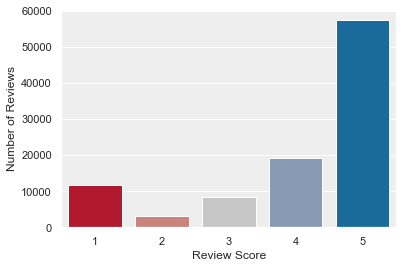

In [ ]:
# we define the figure attributes for consisency
sns.set()
REVIEWS_PALETTE = sns.color_palette(('#ca0020', '#d57b6f', '#c6c6c6', '#7f9abc', '#0571b0'))
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
resize_plot = lambda: plt.gcf().set_size(12, 5)

# we plot the review score distribution
data = order_reviews_dataset['review_score']
u, inv = np.unique(data, return_inverse=True)
counts = np.bincount(inv)

sns.barplot(
    u, 
    counts, 
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Number of Reviews');

The majority of the reviews are positive with a score of 4-5. The next steps is to figure out how frequently the reviews include written text.

In [ ]:
print('Total number reviews:', order_reviews_dataset.review_id.count())
print('Number of reviews without written text:', len(order_reviews_dataset.review_comment_message)-order_reviews_dataset.review_comment_message.count())
print('In percentage:', round((len(order_reviews_dataset.review_comment_message)-order_reviews_dataset.review_comment_message.count())/len(order_reviews_dataset.review_comment_message)*100),'%')

Total number reviews: 100000
Number of reviews without written text: 58247
In percentage: 58 %


Since only 58% of reviews include written text, it is relevant to figure out how frequently the reviews include written text **for each score**.

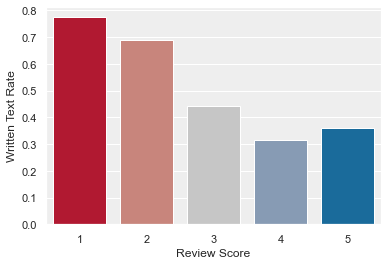

In [ ]:
# we insert a column for the review text length
order_reviews_dataset['review_length'] = order_reviews_dataset['review_comment_message'].str.len()

# using the written text rate, we can show what percentage of reviews have text for each score
def comment_rate(order_reviews_dataset):
    return order_reviews_dataset['review_length'].count() / len(order_reviews_dataset)

comment_rates = order_reviews_dataset.groupby('review_score').apply(comment_rate)
sns.barplot(
    comment_rates.index, 
    comment_rates.values, 
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Written Text Rate');

This clearly shows that customers are more likely to include written text in their review when they are dissatisfied. Around 70% of reviews with scores between 1-2 have written text, while only around 35% of reviews with scores between 4-5 have written text.

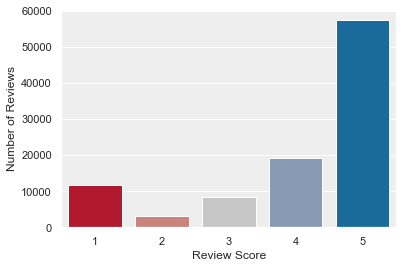

In [ ]:
reviews_with_text = order_reviews_dataset.loc[order_reviews_dataset['review_length'] > 0]

plotdata = order_reviews_dataset['review_score']
# we plot the review score distribution
u, inv = np.unique(plotdata, return_inverse=True)
counts = np.bincount(inv)

sns.barplot(
    u, 
    counts, 
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Number of Reviews');

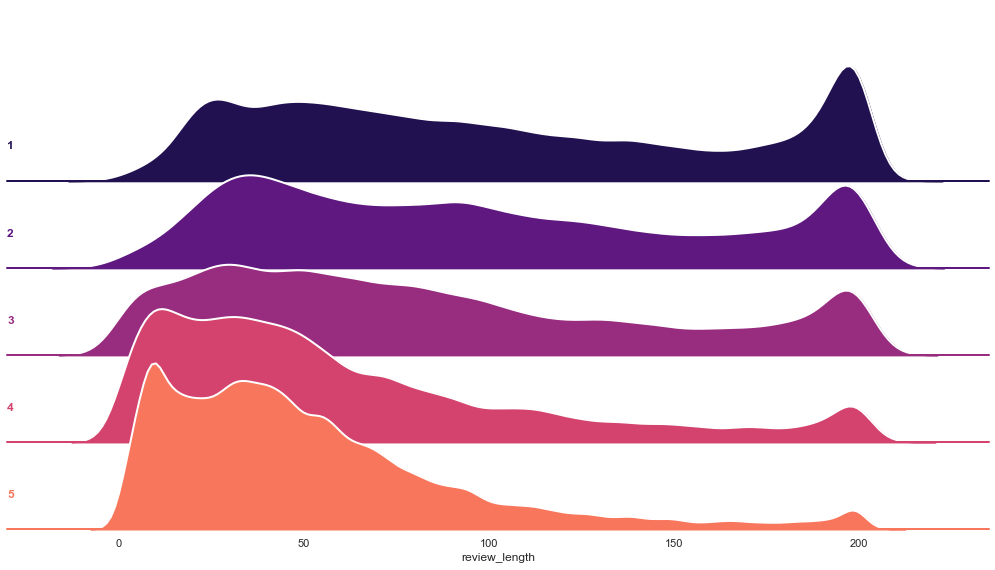

In [ ]:
reviewplot = reviews_with_text.loc[:,['review_score', 'review_length']]
# Initialize the FacetGrid object
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette("magma", as_cmap=False)
g = sns.FacetGrid(reviewplot, row="review_score", hue="review_score", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "review_length",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "review_length", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "review_length")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.gcf().set_size_inches(15, 10)

In [ ]:
print("Average length of 4-5 reviews:", round(reviews_with_text[reviews_with_text['review_score'] > 3]['review_length'].mean()), "words")
print("Average length of 1-3 reviews:", round(reviews_with_text[reviews_with_text['review_score'] <= 3]['review_length'].mean()), "words")

Average length of 4-5 reviews: 55 words
Average length of 1-3 reviews: 97 words


This shows that dissatisfied customers are more likely to write longer review texts.

### WordCloud Analysis

When doing the WordCloud, we will only consider reviews with written text. Furthermore, since most written reviews are either 1 or 5, we will include word clouds for these 

In [ ]:
stopwords = portugese_stopwords
# we got this code from the lectures
def show_wordcloud(data, title, column):
    text = ' '.join(data[column].astype(str).tolist())
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

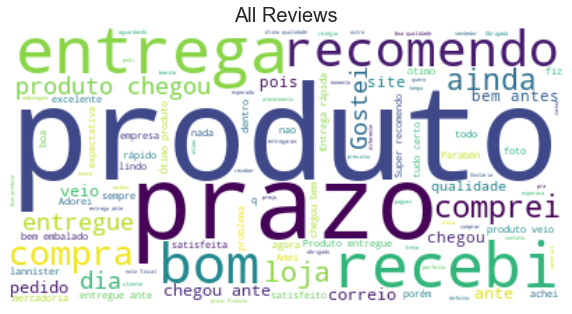

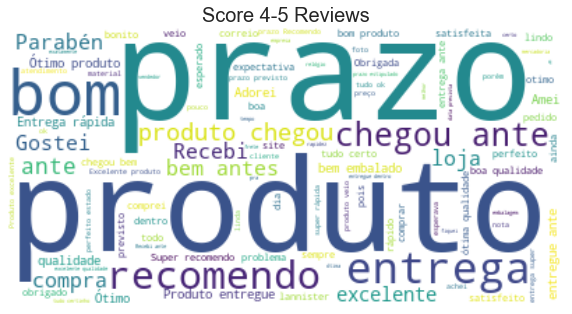

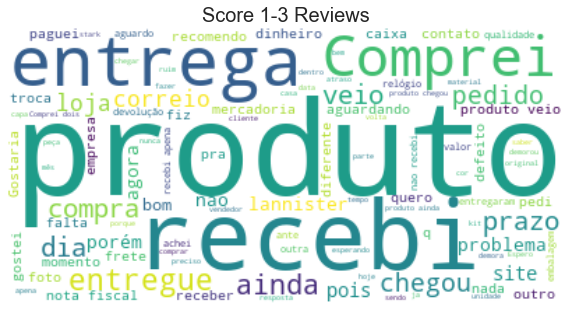

In [ ]:
good_reviews_data = reviews_with_text.loc[reviews_with_text['review_score'] > 3]
bad_reviews_data = reviews_with_text.loc[reviews_with_text['review_score'] <= 3]

show_wordcloud(reviews_with_text,'All Reviews','review_comment_message')
show_wordcloud(good_reviews_data,'Score 4-5 Reviews','review_comment_message')
show_wordcloud(bad_reviews_data,'Score 1-3 Reviews','review_comment_message')

## Text Preprocessing
We will preprocess the text in these steps: remove stopwords, lower case, special characters, removing punctuation, removing rare words, removing numbers, stemming

In [ ]:
nltk.download('rslp')
st = RSLPStemmer()

stopwords = portugese_stopwords
# we decided to remove these words as they did not contribute to the analysis
#our_stopwords = ['produto', 'recebi', 'ainda', 'entrega', 'entregue']
our_stopwords = []
for word in our_stopwords:
    stopwords.append(word)

def text_processing(text):
    # remove punctuation
    text = "".join([c for c in text
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    #remove stopwords
    text = " ".join([w for w in text.split()
                     if w not in stopwords])
    #stemming
    text = " ".join([st.stem(word) for word in text.split()])
    
    # remove numbers
    text = "".join([c for c in text if c not in '0123456789'])
    
    return text

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
reviews_with_text['review_message_clean'] = reviews_with_text['review_comment_message'].apply(text_processing)

reviews_with_text[['review_comment_message','review_message_clean']].head()

,review_comment_message,review_message_clean
3,Recebi bem antes do prazo estipulado.,receb bem ant praz estipul
4,Parabéns lojas lannister adorei comprar pela I...,parabém loj lannist ador compr internet segur ...
9,aparelho eficiente. no site a marca do aparelh...,aparelh efici sit marc aparelh impress desinfe...
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouc travandopel val ta boa
15,"Vendedor confiável, produto ok e entrega antes...",vend confi produt ok entreg ant praz


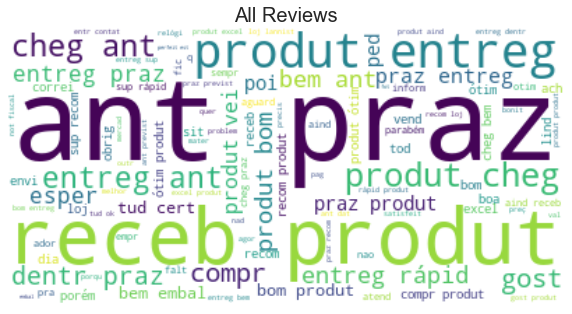

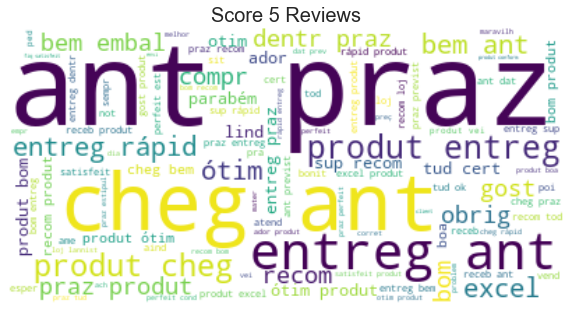

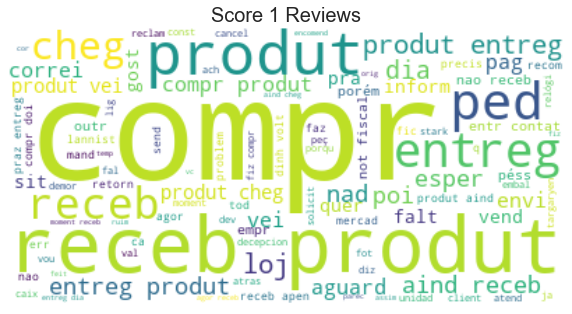

In [ ]:
# we will now try to do the wordclouds for the cleaned text

good_reviews_data = reviews_with_text.loc[reviews_with_text['review_score'] == 5]
bad_reviews_data = reviews_with_text.loc[reviews_with_text['review_score'] == 1]

show_wordcloud(reviews_with_text,'All Reviews','review_message_clean')
show_wordcloud(good_reviews_data,'Score 5 Reviews','review_message_clean')
show_wordcloud(bad_reviews_data,'Score 1 Reviews','review_message_clean')

# Topic Modelling

## LDA

In [ ]:
from gensim.models.ldamodel import LdaModel
from tqdm.notebook import tqdm
from gensim.corpora import Dictionary
from gensim.models import Phrases, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
rs = 42 # reproducible results, set to None for random
sampled = reviews_with_text.sample(frac=0.1, random_state=rs)

f = lambda x: x.split()

tokens = sampled['review_message_clean'].map(f).tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(tok) for tok in tokens]
tfidf = TfidfModel(corpus, normalize=True)
corpus = tfidf[corpus]

In [ ]:
dictionary[63]
df = pd.DataFrame(list(tfidf.idfs.items())).sort_values(by=1, ascending=False)
df[0].replace(dictionary.id2token, inplace=True)
df[df[1]<5]

,0,1
66,esper,4.940098
331,excel,4.723780
8,ped,4.635243
4,dia,4.543745
118,rápid,4.420230
102,ótim,4.369349
64,aind,4.341060
53,loj,4.320201
36,gost,4.201012
47,ant_praz,4.027560


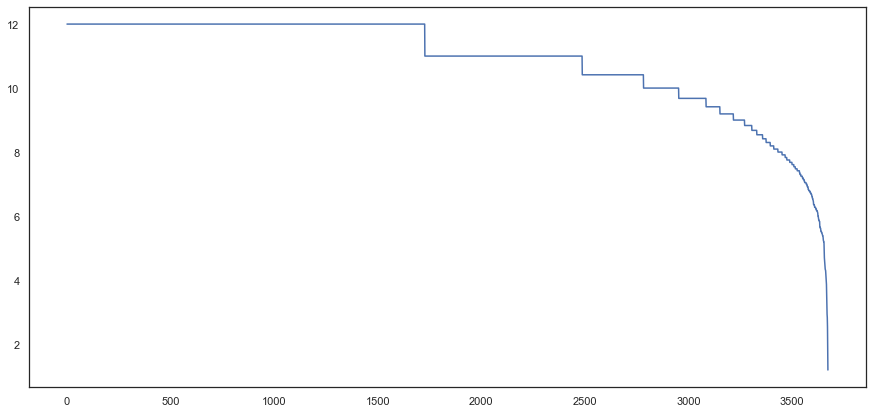

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(df[1].values)
plt.show()

In [ ]:
our_stopwords = df[df[1]<5][0]
for word in our_stopwords:
    stopwords.append(word)

def text_processing_stop(text):
    # remove punctuation
    text = "".join([c for c in text
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #stemming
    text = " ".join([st.stem(word) for word in text.split()])
    
    # remove numbers
    text = "".join([c for c in text if c not in '0123456789'])
    
    #remove stopwords
    text = " ".join([w for w in text.split()
                     if w not in stopwords])
    
    return text

In [ ]:
sampled['review_message_clean_stop'] = sampled['review_comment_message'].apply(text_processing_stop)
tokens = sampled['review_message_clean_stop'].map(f).tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(tok) for tok in tokens]
tfidf = TfidfModel(corpus, normalize=True)
corpus = tfidf[corpus]

### Bad Reviews

In [ ]:
bad_reviews = np.array(corpus)[sampled['review_score']==1].tolist()

In [ ]:
grid_search_bad = pd.DataFrame(columns=['alpha', 'eta', 'n_topics', 'coherence'])
for alpha in tqdm(np.arange(0.01, 0.8, 0.2)):
    for eta in tqdm(np.arange(0.01, 0.8, 0.2), leave=False):
        for n_topics in tqdm(range(2, 10), leave=False):
            lda_bad = LdaModel(corpus=bad_reviews, id2word=dictionary, num_topics=n_topics,
                                   passes=5, alpha=alpha, eta=eta, random_state=rs)
            coherence_model_lda = CoherenceModel(model=lda_bad, texts=tokens, dictionary=dictionary, coherence='c_v')
            grid_search_bad = grid_search_bad.append({'alpha': alpha,
                                              'eta': eta,
                                              'coherence': coherence_model_lda.get_coherence(),
                                              'n_topics': n_topics}, ignore_index=True)

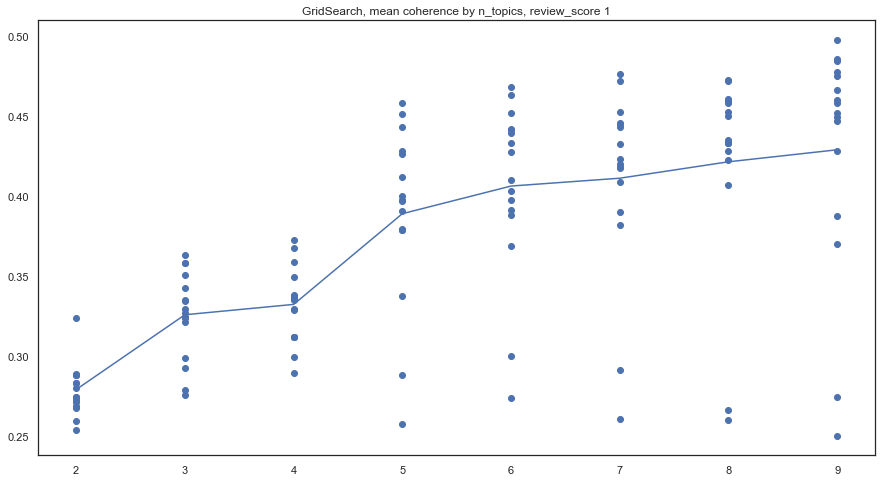

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(grid_search_bad.n_topics, grid_search_bad.coherence)
plt.plot(grid_search_bad.groupby('n_topics').mean()['coherence'])
plt.title('GridSearch, mean coherence by n_topics, review_score 1')
plt.show()

In [ ]:
n_topics_bad = 6

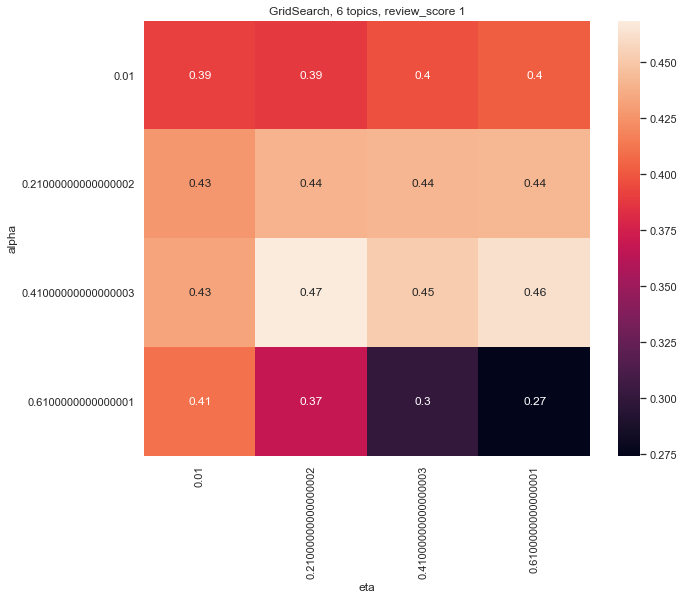

In [ ]:
grid_bad = grid_search_bad[grid_search_bad.n_topics == n_topics_bad].groupby(['alpha', 'eta'])['coherence'].mean().unstack()
plt.figure(figsize=(10,8))
sns.heatmap(grid_bad,annot=True)
plt.title('GridSearch, {} topics, review_score 1'.format(n_topics_bad))
plt.show()

In [ ]:
alpha = 0.2
eta = 0.01

In [ ]:
lda_bad = LdaModel(corpus=bad_reviews, id2word=dictionary, num_topics=n_topics_bad,
                                   passes=5, alpha=alpha, eta=eta, random_state=rs)

lda_bad.print_topics()

[(0,
  '0.017*"hoj" + 0.017*"agor" + 0.013*"doi" + 0.012*"est" + 0.010*"par" + 0.010*"const" + 0.008*"dat" + 0.008*"statu" + 0.008*"pra" + 0.007*"pess"'),
 (1,
  '0.023*"est" + 0.009*"defeit" + 0.008*"péss" + 0.008*"troc" + 0.008*"par" + 0.007*"cad" + 0.007*"infeliz" + 0.007*"soment_unidad" + 0.007*"envi" + 0.007*"tiv_retorn"'),
 (2,
  '0.039*"nao" + 0.013*"outr" + 0.012*"falt" + 0.009*"lannist" + 0.009*"dem" + 0.009*"tenh" + 0.008*"poi" + 0.007*"par" + 0.007*"voc" + 0.007*"ess"'),
 (3,
  '0.023*"est_aguard" + 0.018*"par" + 0.014*"demor" + 0.011*"mercad" + 0.010*"pass" + 0.010*"fiz" + 0.009*"ess" + 0.008*"apen" + 0.008*"pag" + 0.008*"absurd"'),
 (4,
  '0.013*"inform" + 0.013*"est" + 0.013*"cancel" + 0.013*"atras" + 0.011*"unidad" + 0.010*"quer" + 0.009*"nad" + 0.009*"nao" + 0.008*"par" + 0.008*"parc"'),
 (5,
  '0.021*"moment" + 0.015*"quer_dinh_volt" + 0.010*"est" + 0.010*"minh" + 0.009*"falsific" + 0.009*"difer" + 0.009*"ate_agor" + 0.009*"decepcion" + 0.009*"avis" + 0.007*"reembols"'

### Good Reviews

In [ ]:
good_reviews = np.array(corpus)[sampled['review_score']==5].tolist()

In [ ]:
grid_search_good = pd.DataFrame(columns=['alpha', 'eta', 'n_topics', 'coherence'])
for alpha in tqdm(np.arange(0.01, 0.8, 0.2)):
    for eta in tqdm(np.arange(0.4, 1.2, 0.2), leave=False):
        for n_topics in tqdm(range(2, 10), leave=False):
            lda_good = LdaModel(corpus=good_reviews, id2word=dictionary, num_topics=n_topics,
                                   passes=5, alpha=alpha, eta=eta, random_state=rs)
            coherence_model_lda = CoherenceModel(model=lda_good, texts=tokens, dictionary=dictionary, coherence='c_v')
            grid_search_good = grid_search_good.append({'alpha': alpha,
                                              'eta': eta,
                                              'coherence': coherence_model_lda.get_coherence(),
                                              'n_topics': n_topics}, ignore_index=True)

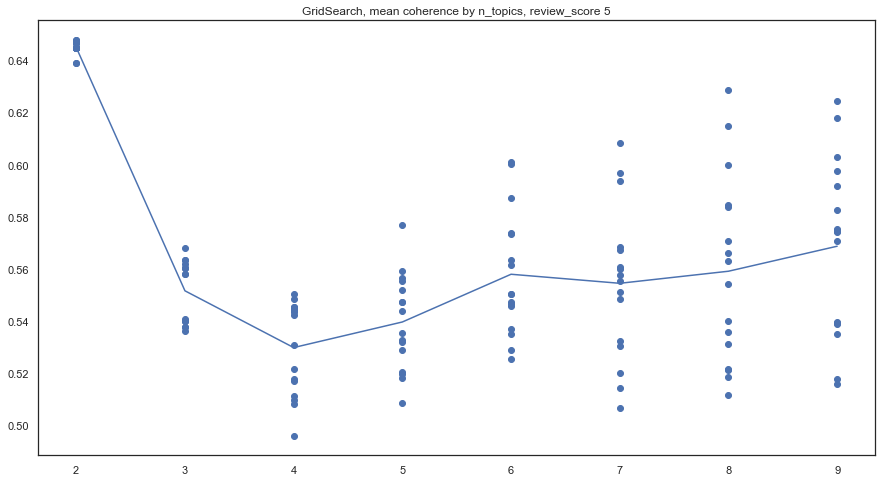

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(grid_search_good.n_topics, grid_search_good.coherence)
plt.plot(grid_search_good.groupby('n_topics').mean()['coherence'])
plt.title('GridSearch, mean coherence by n_topics, review_score 5')
plt.show()

In [ ]:
n_topics_good = 6

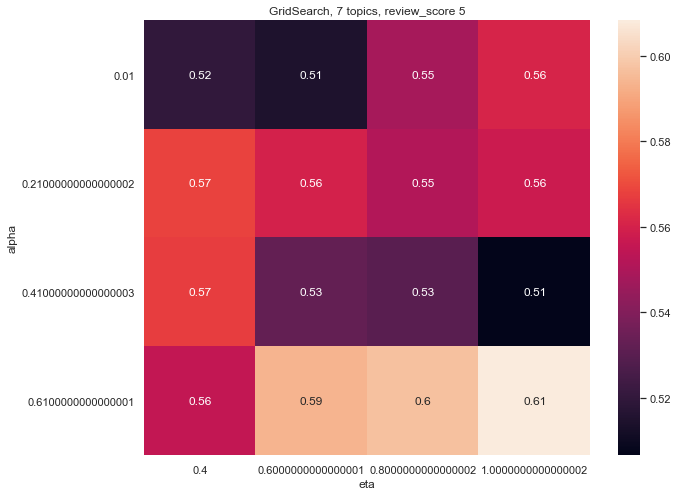

In [ ]:
grid_good = grid_search_good[grid_search_good.n_topics == n_topics_good].groupby(['alpha', 'eta'])['coherence'].mean().unstack()
plt.figure(figsize=(10,8))
sns.heatmap(grid_good,annot=True)
plt.title('GridSearch, {} topics, review_score 5'.format(n_topics_good))
plt.show()

In [ ]:
alpha = 0.6
eta = 1

In [ ]:
lda_good = LdaModel(corpus=good_reviews, id2word=dictionary, num_topics=n_topics_good,
                                   passes=5, alpha=alpha, eta=eta, random_state=rs)

lda_good.print_topics()

[(0,
  '0.020*"perfeit" + 0.010*"prev" + 0.010*"bem_ant_dat" + 0.009*"pres" + 0.009*"sei" + 0.009*"ok" + 0.009*"cert" + 0.008*"porqu" + 0.007*"inform" + 0.001*"lind"'),
 (1,
  '0.032*"ant_dat_prev" + 0.015*"serviç" + 0.012*"nenhum_problem" + 0.012*"ant" + 0.009*"😍😍" + 0.009*"marc" + 0.008*"am" + 0.008*"ant_dat" + 0.006*"iss" + 0.005*"otim"'),
 (2,
  '0.027*"ant" + 0.016*"top" + 0.016*"atend" + 0.015*"previs" + 0.013*"corret" + 0.011*"minh_sal" + 0.010*"comp" + 0.009*"combin" + 0.008*"exat" + 0.007*"sempr"'),
 (3,
  '0.027*"sup" + 0.011*"avenç" + 0.009*"tud" + 0.008*"vend" + 0.008*"cumpr" + 0.004*"boa" + 0.001*"conform_anunci" + 0.001*"efici" + 0.001*"promet" + 0.001*"tud_cert"'),
 (4,
  '0.030*"ador" + 0.014*"agil" + 0.003*"tod" + 0.002*"not" + 0.001*"lannist" + 0.001*"tud_perfeit" + 0.001*"nunc_tiv_problem" + 0.001*"confi" + 0.001*"tud_conform" + 0.001*"minh"'),
 (5,
  '0.017*"ameiiiiiiii" + 0.010*"sony" + 0.009*"conform_solicit" + 0.008*"tv" + 0.007*"control" + 0.003*"ame" + 0.003*"a

## Graph analysis

In [ ]:
from itertools import combinations
import networkx as nx

In [ ]:
edges = pd.DataFrame()
for topic in range(n_topics_bad):
    edges = edges.append([lda_bad.id2word[term] for term in [lda_bad.get_topic_terms(topic)[word][0] for word in range(10)]], ignore_index=True)
bad_top = pd.unique(edges[0])

edges = pd.DataFrame()
for topic in range(n_topics_good):
    edges = edges.append([lda_good.id2word[term] for term in [lda_good.get_topic_terms(topic)[word][0] for word in range(10)]], ignore_index=True)
good_top = pd.unique(edges[0])
del edges

In [ ]:
reviews_15 = sampled[(sampled['review_score']==5) | (sampled['review_score']==1)]
threshold = 0

In [ ]:
bad_whitelist = df[(df[0].isin(bad_top.tolist())) & (df[1] > threshold)][0].tolist()

def graph_text_processing_1(text):
    # remove punctuation
    text = "".join([c for c in text
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #stemming
    text = " ".join([st.stem(word) for word in text.split()])
    
    # remove numbers
    text = "".join([c for c in text if c not in '0123456789'])
    
    #remove stopwords
    text = " ".join([w for w in text.split()
                     if w in bad_whitelist])
    
    return text

reviews_15['review_message_clean_graph'] = reviews_15['review_comment_message'].apply(graph_text_processing_1)

tokens = reviews_15['review_message_clean_graph'].map(f).tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
bad_tokens = list(trigram_model[bigram_model[tokens]])

In [ ]:
good_whitelist = df[(df[0].isin(good_top.tolist())) & (df[1] > threshold)][0].tolist()
    
def graph_text_processing_2(text):
    # remove punctuation
    text = "".join([c for c in text
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #stemming
    text = " ".join([st.stem(word) for word in text.split()])
    
    # remove numbers
    text = "".join([c for c in text if c not in '0123456789'])
    
    #remove stopwords
    text = " ".join([w for w in text.split()
                     if w in good_whitelist])
    
    return text

reviews_15['review_message_clean_graph'] = reviews_15['review_comment_message'].apply(graph_text_processing_2)

tokens = reviews_15['review_message_clean_graph'].map(f).tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
good_tokens = list(trigram_model[bigram_model[tokens]])

In [ ]:
bad_tok = pd.DataFrame(bad_tokens, index=reviews_15.index)
bad_tok = bad_tok.dropna(how='all')

bad_entok = pd.get_dummies(bad_tok)
bad_uncol = pd.unique([col[col.find('_')+1:] for col in bad_entok.columns])

good_tok = pd.DataFrame(good_tokens, index=reviews_15.index)
good_tok = good_tok.dropna(how='all')

good_entok = pd.get_dummies(good_tok)
good_uncol = pd.unique([col[col.find('_')+1:] for col in good_entok.columns])

In [ ]:
bad_clean_entok = pd.DataFrame()
for cols in tqdm(bad_uncol):
    aux = [s for s in bad_entok.columns if cols == s[s.find('_')+1:]]
    bad_clean_entok[cols] = bad_entok.loc[:,aux].sum(axis=1)
del bad_entok, bad_uncol, bad_tok

good_clean_entok = pd.DataFrame()
for cols in tqdm(good_uncol):
    aux = [s for s in good_entok.columns if cols == s[s.find('_')+1:]]
    good_clean_entok[cols] = good_entok.loc[:,aux].sum(axis=1)
del good_entok, good_uncol, good_tok

In [ ]:
bad_final_list = []
for col in tqdm(range(len(bad_clean_entok.columns))):
    h = bad_clean_entok.iloc[:,col][bad_clean_entok.iloc[:,col]==1].index
    for i in combinations(h,2):
        bad_final_list.append(i)
bad_final_list = pd.DataFrame(bad_final_list)

good_final_list = []
for col in tqdm(range(len(good_clean_entok.columns))):
    h = good_clean_entok.iloc[:,col][good_clean_entok.iloc[:,col]==1].index
    for i in combinations(h,2):
        good_final_list.append(i)
good_final_list = pd.DataFrame(good_final_list)

In [ ]:
def get_digraph_from_df(df_g):
    G = nx.Graph() # directed graph
    for index, row in df_g.iterrows():
        G.add_edge(row[0], row[1])
    return G

In [ ]:
G_full_bad = get_digraph_from_df(bad_final_list)
print(nx.info(G_full_bad))

G_full_good = get_digraph_from_df(good_final_list)
print(nx.info(G_full_good))

Name: 
Type: Graph
Number of nodes: 1123
Number of edges: 97514
Average degree: 173.6670
Name: 
Type: Graph
Number of nodes: 1995
Number of edges: 344454
Average degree: 345.3173


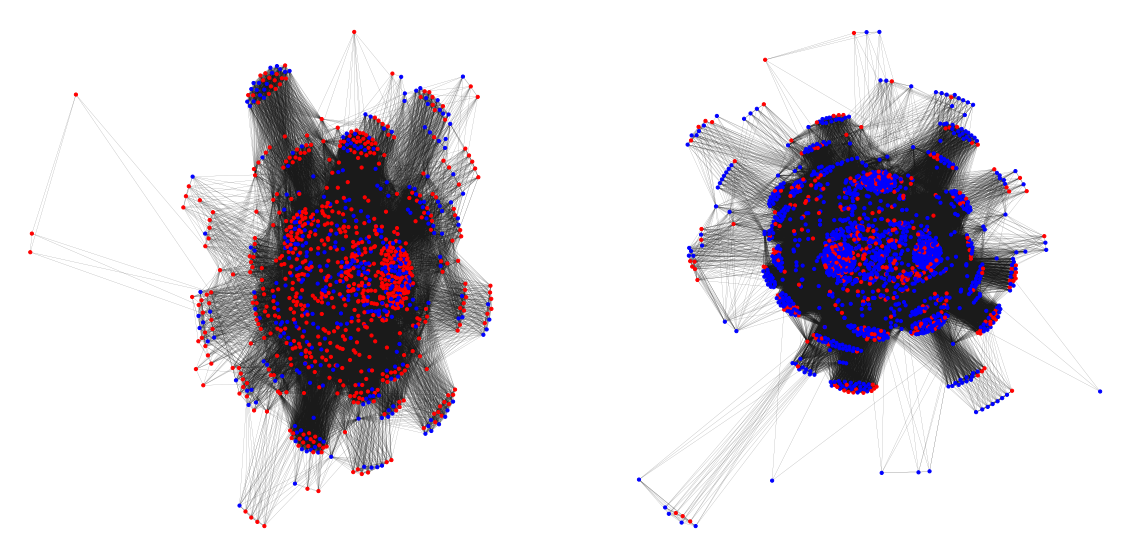

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

color_map_bad = reviews_15.loc[np.unique(bad_final_list).tolist(),'review_score'].replace({5:'blue', 1:'red'})
color_map_good = reviews_15.loc[np.unique(good_final_list).tolist(),'review_score'].replace({5:'blue', 1:'red'})

pos_bad = nx.spring_layout(G_full_bad, k=0.15)
nx.draw(G_full_bad, pos=pos_bad,node_color=color_map_bad, node_size = 10, width = 0.1, ax=ax[0])

pos_good = nx.spring_layout(G_full_good, k=0.15)
nx.draw(G_full_good, pos=pos_good,node_color=color_map_good, node_size = 10, width = 0.1, ax=ax[1])

plt.show()

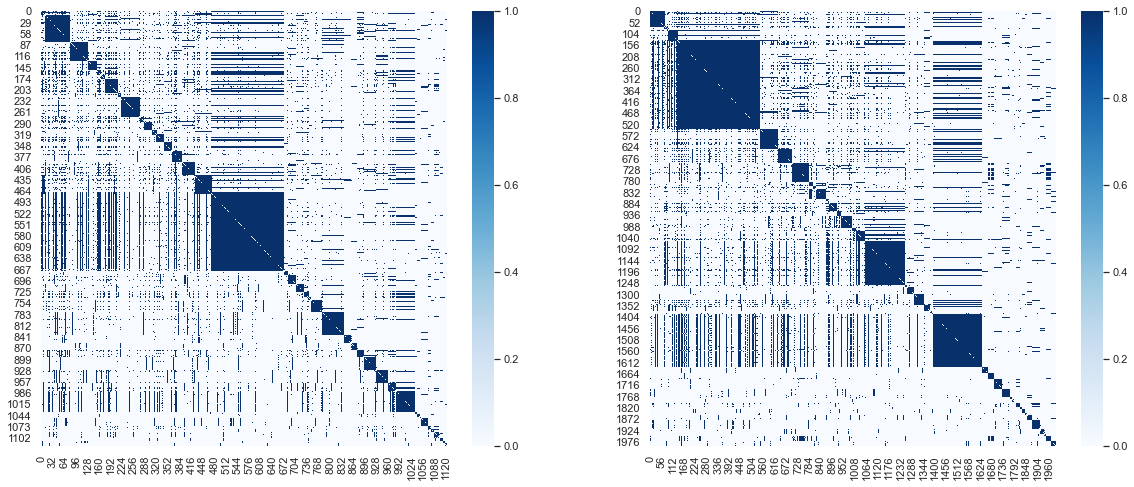

Density bad 15.478%
Density good 17.318%


In [ ]:
f, axes = plt.subplots(1, 2, figsize=(20,8))

A_bad = nx.to_numpy_matrix(G_full_bad)
sns.heatmap(A_bad, cmap=plt.cm.Blues, ax=axes[0])
A_good = nx.to_numpy_matrix(G_full_good)
sns.heatmap(A_good, cmap=plt.cm.Blues, ax=axes[1])

plt.show()
print("Density bad {:.3%}".format(A_bad.sum()/(A_bad.shape[0]**2-A_bad.shape[0])))
print("Density good {:.3%}".format(A_good.sum()/(A_good.shape[0]**2-A_good.shape[0])))

In [ ]:
print("Average node degree =", 
      np.mean(list(dict(G_full_bad.degree()).values())))
print("Average node degree =", 
      np.mean(list(dict(G_full_good.degree()).values())))

Average node degree = 173.66696349065003
Average node degree = 345.3172932330827


In [ ]:
from collections import OrderedDict
def get_top_centrality(G, func, top_n=10):
    degree_cent = func(G)
    degree_cent_ordered = OrderedDict(sorted(degree_cent.items(), 
                                             reverse=True, 
                                             key=lambda x: x[1])[:top_n])
    return degree_cent_ordered

In [ ]:
# Top people by degree centrality
dc_cent_bad = get_top_centrality(G_full_bad, nx.degree_centrality)
dc_cent_good = get_top_centrality(G_full_good, nx.degree_centrality)

In [ ]:
pd.options.display.max_colwidth = 2000
sampled.loc[list(dc_cent_bad.keys()),'review_comment_message']

40299     Estou com sério problema fiz uma super compra pra vim faltando o meu produto ... e além do mais pagar um frete absurdo para ser entregue pra vim ainda com constrangimento ... quero que resolva logo
31357                                               O produto é bom, mas a lannister deve estar fazendo uma promoção às avessas, pois paguei 2 mas recebi só 1, já fiz a reclamação no site mas até agora nada!
56555                                                               Meu produto veio errado. Outra estamos. Fiz contato no dia do recebimento dia 24 para devolução e até agora nda...estou aguardando ainda...
98136              Primeiro que minha compra estava vinculada a outra, e eu não consegui um dos produtos (celular). Então vou pagar por um produto inútil para mim, uma vez que não consegui cancelar a compra.
48650             LOJAS lannister ESPERO O RETORNO DE VOCES!!!!!!!!!!!! FIZ O PEDIDO DE CANCELAMENTO ASSIM QUE A MERCADORIA CHEGOU E JA ESTA ACABANDO O PRAZO ATE AGORA 

In [ ]:
sampled.loc[list(dc_cent_good.keys()),'review_comment_message']

53102                            Foi muito bom, dentro das minhas expectativas. Vendedor entregou o produto antes do prazo final, bem embalado, produto correto com nota fiscal, tudo certinho. Está de parabéns.
86013    Produto aparentemente ótimo, chegou muito antes do prazo estipulado pelo site. Pena que comprei o produto errado "era para ser bomba submersa com filtro". Mas, já estou resolvendo tudo quanto a troca.
81621                   Fiquei muito satisfeito com a compra. O produto chegou antes do prazo previsto. Por se tratar de um material eletrônico, ainda irei testar seu funcionamento, mas penso que está tudo ok.
47032                                                                                                                            RECEBI MEUS PRODUTOS EM PERFEITO ESTADO E ANTES DO PRAZO... MUITO BOM ADOOOREI!!
23223                                                                                                        Estou muito satisfeito,sempre compro com vocês e nu